In [1]:
import numpy as np
import pylab as pl
from scipy.io import wavfile
from scipy.io.wavfile import write
from IPython.display import Audio

sample_rate, ref_audio=wavfile.read('audio_samples\\audio_sample.wav')
sr, test_noise=wavfile.read('audio_samples\\mowa.wav')

In [2]:
class RLS:

    # RLS params
    N = 10           # filter lenght
    l = 0.99         # weight param

    S = np.zeros([N,N])     # amplifying matrix
    x = np.zeros(N)         # input
    w = np.zeros(N)

    def __init__(self, start_samples, N = 10, l = 0.99):
        self.N = N
        self.l = l
        self.S = np.eye(self.N) * 100
        self.w = np.zeros(N)
        self.x = start_samples

    def insert(self, new_sample):
        self.x = np.roll(self.x,1)
        self.x[0] = new_sample

    def update(self, e):
        psi = self.S @ self.x
        self.S = (self.S - (np.outer(psi, psi))/(self.l + np.inner(psi, self.x)))/self.l

        self.w += e * (self.S @ self.x)

    def estimate(self):
        return np.inner(self.x, self.w)

In [3]:
class LMS:
    
    # LMS params
    N = 0          # filter length
    u = 0          # starting learing rate

    x = np.zeros([N])
    h = np.zeros([N])

    def __init__(self, start_samples, N = 10, u = 0.01):
        self.N = N
        self.u = u
        self.x = start_samples
        self.h = np.zeros(self.N) #starting FIR coefficient

    def update(self, e):
        gamma = 1 # used to avoid devision by 0
        mu = self.u/(gamma + np.dot(self.x, self.x))
        self.h += mu * e * self.x

    def estimate(self):
        return np.dot(self.x,self.h)

    def insert(self, new_sample):
        self.x = np.roll(self.x,1)
        self.x[0] = new_sample

In [4]:
class system:

    y = np.empty([])
    e = np.empty([])

    x = np.empty([])
    d = np.empty([])

    RLS1 = RLS([])
    LMS1 = LMS([])

    s = 0
    k_r = 0
    k_l = 0

    def __init__(self, x, d, LMS0=LMS([]), RLS0=RLS([])):

        self.RLS1 = RLS0
        self.LMS1 = LMS0
        self.x = x
        self.d = d
        
        self.s = np.size(self.x)

        self.y = np.zeros(self.s)
        self.e = np.zeros(self.s)

        self.k_l = self.LMS1.N
        self.k_r = self.RLS1.N

    def calculate_RLS(self):
        for n in range(self.RLS1.N, self.s):
            self.RLS1.insert(self.x[n])
            self.y[n-self.k_r] = self.RLS1.estimate()
            self.e[n-self.k_r] = self.d[n] - self.y[n-self.k_r]
            self.RLS1.update(self.e[n-self.k_r])
        return self.e, self.y

    def calculate_LMS(self):
        for n in range(self.LMS1.N, self.s):
            self.LMS1.insert(self.x[n])
            self.y[n-self.k_l] = self.LMS1.estimate()
            self.e[n-self.k_l] = self.d[n] - self.y[n-self.k_l]
            self.LMS1.update(self.e[n-self.k_l])
        return self.e, self.y

    def plot(self, d, e, y):
        fig, ax = pl.subplots( nrows=3 )
        fig.set_size_inches( 24, 16 )
        fig.suptitle( "Result of adaptive filtering", fontsize=12 )
        ax[0].plot( d, label="desired signal")
        ax[0].legend()

        ax[1].plot( e, label="filtered signal" )
        ax[1].plot( self.d, label="raw signal", alpha = 0.5 )
        ax[1].legend()

        ax[2].plot(y, label = "anti-sound")
        ax[2].legend()
        pl.show()

In [5]:
class audio_converter:
    def wav_to_data(path):
        sampleRateWav, data = wavfile.read(path)
        print("Data extracted from wav!")
        return sampleRateWav, data[:,0], data[:,1]  #this represent both Left and Right Channel    

    def data_to_wav(name, sampleRate, data_L, data_R ): 
        print("Data saved to wav!")       
        return write(name, sampleRate, np.vstack((data_L, data_R)).T.astype(np.int16))

In [6]:
ref_audio = np.array(ref_audio, dtype = float)

audio_l = ref_audio[:,0]
audio_r = ref_audio[:,1]

noise = 3000

test_noise = np.random.rand(np.size(audio_l))*noise - np.ones(np.size(audio_l))*noise/2
test_noise = np.array(test_noise, dtype=float)

# test_noise = test_noise[:,0]
# test_noise = 2.5 * test_noise[0:audio_l.size]

audio_l = audio_l + test_noise
audio_r = audio_r + test_noise

k = 6
s = audio_l.size

start = test_noise[k:0:-1]

In [7]:
RLSL = RLS(start, N=k, l=0.9999)
RLSR = RLS(start, N=k, l=0.9999)

sysl = system(test_noise, audio_l, RLS0 = RLSL)
sysr = system(test_noise, audio_r, RLS0 = RLSR)

e_rls_l, y_rls_l = sysl.calculate_RLS()

e_rls_r, y_rls_r = sysr.calculate_RLS()

In [8]:
LMSL = LMS(start, N=k, u=0.01)
LMSR = LMS(start, N=k, u=0.01)

sysl = system(test_noise, audio_l, LMS0 = LMSL)
sysr = system(test_noise, audio_r, LMS0 = LMSR)

e_lms_l, y_lms_l = sysl.calculate_LMS()

e_lms_r, y_lms_r = sysr.calculate_LMS()

In [9]:
audio_converter.data_to_wav("Corrupted_audio.wav", sample_rate,audio_l,audio_r)
audio_converter.data_to_wav("RLS_filtered.wav",sample_rate,e_rls_l,e_rls_r)
audio_converter.data_to_wav("LMS_filtered.wav",sample_rate,e_lms_l,e_lms_r)

print('referencial audio')
display(Audio(data=ref_audio.T, rate=sample_rate))

print('corrupted audio')
display(Audio('Corrupted_audio.wav'))

print('lms filtered audio')
display(Audio("LMS_filtered.wav"))

print('rls filtered audio')
display(Audio("RLS_filtered.wav"))

Data saved to wav!
Data saved to wav!
Data saved to wav!
referencial audio


corrupted audio


lms filtered audio


rls filtered audio


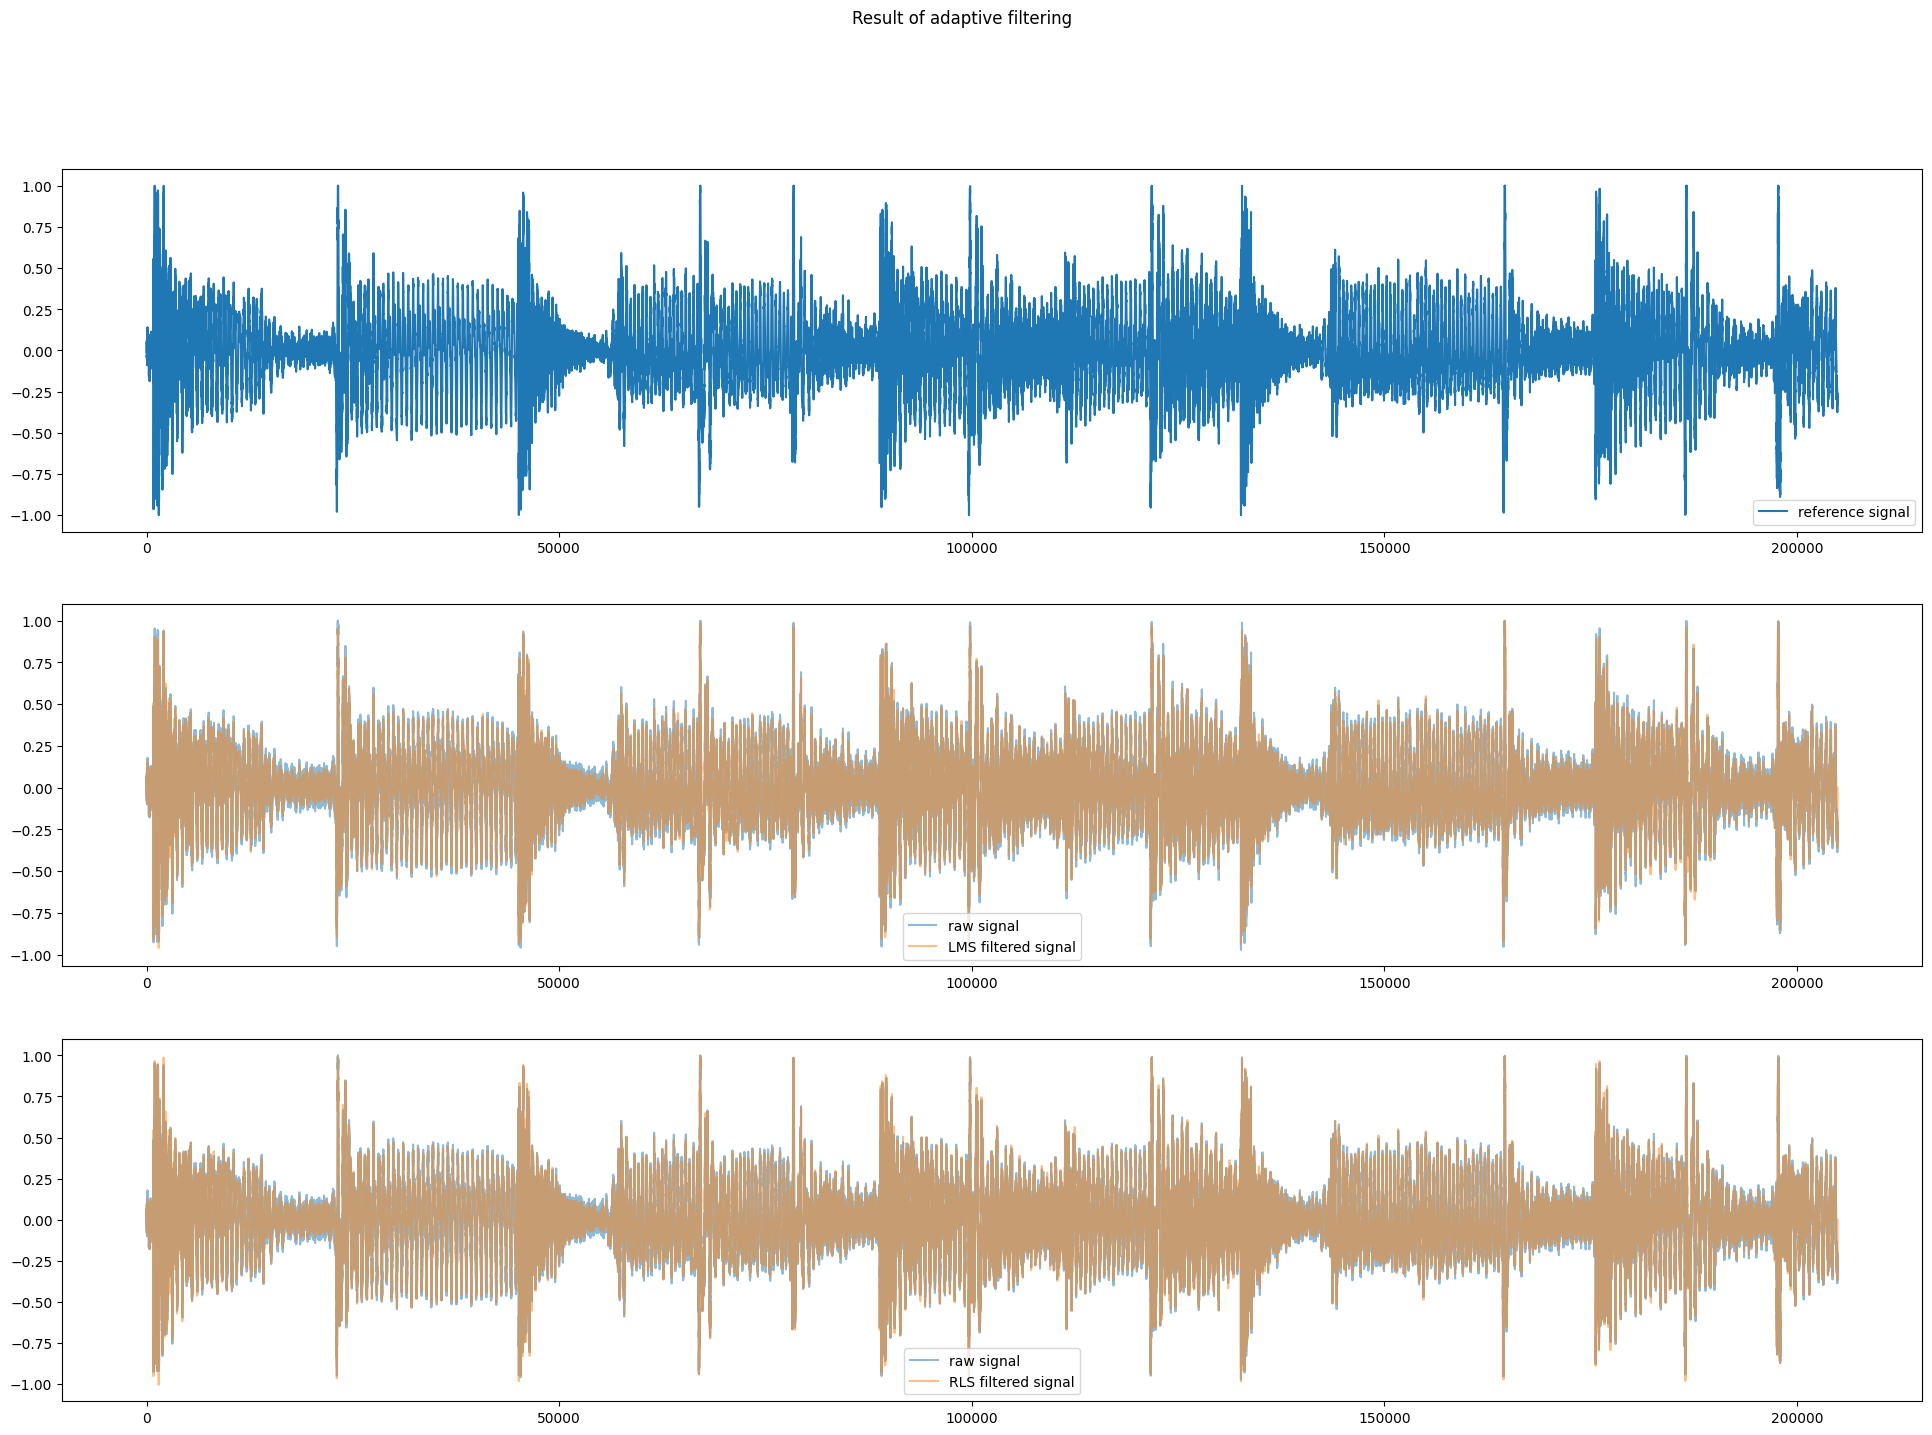

In [14]:
fig, ax = pl.subplots( nrows=3 )
fig.set_size_inches( 24, 16 )
fig.suptitle( "Result of adaptive filtering", fontsize=12 )

ax[0].plot( ref_audio[:,0]/max(ref_audio[:,0]), label="reference signal" )
ax[0].legend()

ax[1].plot( audio_l/max(audio_l), label="raw signal", alpha = 0.5 )
ax[1].plot( e_lms_l/max(e_lms_l), label="LMS filtered signal", alpha  = 0.5 )
ax[1].legend()

ax[2].plot( audio_l/max(audio_l), label="raw signal", alpha = 0.5 )
ax[2].plot( e_rls_l/max(e_rls_l), label="RLS filtered signal", alpha  = 0.5 )
ax[2].legend()
